# 3. Modeling: Feature Engineering & Clustering

## 3.1 Contents<a id='3.1'></a>
* [3.1 Contents](#3.1)
* [3.2 Introduction](#3.2)
* [3.3 Imports](#3.3)
* [3.4 Load Data & Set Options](#3.4)
* [3.5 Feature Engineering: Add Redemption Rate to Table](#3.5)
* [3.6 Modeling: Regression](#3.6)
    * [3.6.1 K Means Clustering](#3.6.1)
    * [3.6.2 KNN Model](#3.6.2)
    * [3.6.3 XGBoost: Regression Model](#3.6.3)
* [3.7 XGB Classification Model: Will a customer use a coupon?](#3.7)
* [3.8 Discussion](#3.8)
* [3.9 Next Steps](#3.9)
* [3.10 Exporting the Data](#3.10)



## 3.2 Introduction  <a id='3.2'></a>

In the last notebook, I performed pre-processing of my data by creating a table which included weekly sales totals for each household along with their demographics, and did not include the transaction data for which there was no demographic data. I then ran two baseline models (KNN and OLS) to get an idea as to where I stood without additional feature engineering. I found that my error was very high, but that most of the features are statistically significant in their contributions towards how much a customer spends. 

In this notebook, I will calculate the redemption rate for each household and add it as a feature in my table. I will then perform K Means Clustering, add the clusters as an additional feature, and run KNN and XGBoost regression models to predict total weekly sales values. After that, I will run a baseline XGBoost classification model to predict if a customer will use a coupon or not. 

## 3.3 Imports <a id='3.3'></a>

In [1]:
# Basic Packages and Data Manipulation
import pandas as pd
import numpy as np
from pandasql import sqldf
import pandasql as psql

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning: Preprocessing, Models, and Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, make_scorer, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, recall_score
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# Statistics and Explainability
from scipy.stats import zscore, iqr
from scipy.stats.mstats import winsorize
import scipy.stats.mstats as mstats
import shap




## 3.4 Load  Data<a id='3.4'></a>

In [2]:
campaign_desc = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\campaign_desc.csv")
campaign_table = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\campaign_table.csv")
coupon = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\coupon.csv")
coupon_redempt = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\coupon_redempt.csv")
hh_demographic =pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\hh_demographic.csv") 

transaction_demo = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\transaction_demo.csv")
transaction_demo_weekly = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\transaction_demo_weekly.csv")
weekly_data = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\weekly_data.csv")
coupon_weekly = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\coupon_weekly.csv")
high_sales_high_growth = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\results\high_sales_high_growth.csv")
low_sales_low_growth = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\results\low_sales_low_growth.csv")
low_sales_high_growth = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\results\low_sales_high_growth.csv")
high_sales_low_growth = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\results\high_sales_low_growth.csv")


### Set Options

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Set up my psql
pysql = lambda q: sqldf(q, globals())

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

%matplotlib inline

## 3.5 Feature Engineering: Add Remption Rate to Table  <a id='3.5'></a>
I want to find the coupon redemption rate for each customer, and add this to the transaction_demo_weekly table. The redemption rate won't tell us anything about how much they spend, but I suspect it contributes to spending trends.  

<b> Inspect the tables that I will use to calculate each customer's redemption rate: </b>

In [4]:
campaign_table.head()

,description,household_key,campaign
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


In [5]:
campaign_desc.head()

,description,campaign,start_day,end_day,duration_days
0,TypeB,24,659,719,60
1,TypeC,15,547,708,161
2,TypeB,25,659,691,32
3,TypeC,20,615,685,70
4,TypeB,23,646,684,38


In [6]:
coupon_redempt.head()

,household_key,day,coupon_upc,campaign
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


In [7]:
coupon.head()

,coupon_upc,product_id,campaign
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


In [8]:
# Calculate the number of coupons per campaign:
query = """

SELECT campaign, COUNT(DISTINCT coupon_upc) AS coupon_count
FROM coupon
GROUP BY campaign
"""

coupons_per_campaign = psql.sqldf(query,locals())
coupons_per_campaign

,campaign,coupon_count
0,1,11
1,2,16
2,3,34
3,4,12
4,5,11
5,6,1
6,7,8
7,8,209
8,9,18
9,10,14


In [9]:
# Number of unique coupons: 
coupon.coupon_upc.nunique()

1135

Above I see that campaigns 8, 13 and 18 had the most coupons, which corresponds to what we saw in the EDA notebook, as those were sent out to the most households. 

Next, join the number of coupons per campaign with the households who received these coupons. We will then find out how many coupons they redeemed and get the redemption rate from there. 

<b> Find redemption rate for every customer: </b>

In [10]:
query = """
SELECT t.household_key, SUM(c.coupon_count) AS coupon_count, COUNT(t.campaign) AS num_campaigns
FROM campaign_table AS t
INNER JOIN coupons_per_campaign AS c
ON t.campaign = c.campaign

GROUP BY t.household_key;

"""

hh_coupon_counts = psql.sqldf(query, locals())
hh_coupon_counts

,household_key,coupon_count,num_campaigns
0,1,736,8
1,2,209,1
2,3,442,3
3,4,209,1
4,6,633,4
...,...,...,...
1579,2496,670,5
1580,2497,625,3
1581,2498,658,6
1582,2499,418,2


In [11]:
# Now add in the number of coupons redeemed by each household

query = """
SELECT h.*, COUNT(c.coupon_upc) AS coupons_redeemed, (COUNT(c.coupon_upc)/h.coupon_count * 100) AS redemption_rate
FROM hh_coupon_counts AS h
JOIN coupon_redempt AS c
ON h.household_key = c.household_key
GROUP BY h.household_key
ORDER BY redemption_rate DESC;

"""
result = psql.sqldf(query, locals())
result

,household_key,coupon_count,num_campaigns,coupons_redeemed,redemption_rate
0,2500,711,8,3,0
1,2496,670,5,11,0
2,2494,228,2,5,0
3,2489,973,16,28,0
4,2488,744,9,11,0
...,...,...,...,...,...
429,18,641,4,8,0
430,14,647,5,3,0
431,13,738,10,21,0
432,8,745,10,1,0


In [12]:
result

,household_key,coupon_count,num_campaigns,coupons_redeemed,redemption_rate
0,2500,711,8,3,0
1,2496,670,5,11,0
2,2494,228,2,5,0
3,2489,973,16,28,0
4,2488,744,9,11,0
...,...,...,...,...,...
429,18,641,4,8,0
430,14,647,5,3,0
431,13,738,10,21,0
432,8,745,10,1,0


In [13]:
# Sort the above table to find the max number of coupons redeemed by any customer

query ="""
SELECT household_key, COUNT(coupon_upc) AS num_coupons_redeemed, COUNT(DISTINCT campaign) AS num_campaigns
FROM coupon_redempt
GROUP BY household_key
ORDER BY num_coupons_redeemed DESC;
"""
check = psql.sqldf(query, locals())
check

,household_key,num_coupons_redeemed,num_campaigns
0,367,35,9
1,256,33,10
2,67,33,7
3,1823,30,6
4,931,29,3
...,...,...,...
429,77,1,1
430,68,1,1
431,29,1,1
432,19,1,1


In [14]:
# Calculate number of coupons received by each household

query="""
SELECT t.household_key, COUNT(DISTINCT c.coupon_upc) AS coupons_received
FROM campaign_table AS t
JOIN coupon AS c ON t.campaign = c.campaign
GROUP BY t.household_key;
"""

coupons_received = psql.sqldf(query,locals())
coupons_received

,household_key,coupons_received
0,1,662
1,2,209
2,3,417
3,4,209
4,6,582
...,...,...
1579,2496,612
1580,2497,574
1581,2498,600
1582,2499,404


In [15]:
# Calculate # coupons redeemed by each household

query = """
SELECT household_key, COUNT(coupon_upc) AS coupons_redeemed
FROM coupon_redempt
GROUP BY household_key
ORDER BY coupons_redeemed DESC;
"""

coupons_redeemed = psql.sqldf(query, locals())
coupons_redeemed


,household_key,coupons_redeemed
0,367,35
1,256,33
2,67,33
3,1823,30
4,931,29
...,...,...
429,77,1
430,68,1
431,29,1
432,19,1


In [16]:
# Calculate coupon redemption rate

# Merge the two DataFrames on household_key
hh_redemption = pd.merge(coupons_received, coupons_redeemed, on='household_key', how='left')

# Calculate the redemption rate
hh_redemption['redemption_rate'] = (hh_redemption['coupons_redeemed'] / hh_redemption['coupons_received']) * 100
hh_redemption.head()

,household_key,coupons_received,coupons_redeemed,redemption_rate
0,1,662,5.0,0.755287
1,2,209,NaN,NaN
2,3,417,NaN,NaN
3,4,209,NaN,NaN
4,6,582,NaN,NaN


In [17]:
hh_redemption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   household_key     1584 non-null   int64  
 1   coupons_received  1584 non-null   int64  
 2   coupons_redeemed  434 non-null    float64
 3   redemption_rate   434 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 49.6 KB


In [18]:
# How many of the households didn't redeem coupons (there is NaN)?
hh_redemption['coupons_redeemed'].isna().sum()

1150

In [19]:
# Double checking this to make sure that the number of unique households that redeem coupons is correct.
coupon_redempt['household_key'].nunique()

434

In [20]:
# Turn NaNs into 0

hh_redemption['coupons_redeemed'].fillna(0, inplace=True)
hh_redemption['redemption_rate'].fillna(0, inplace=True)

hh_redemption.sort_values(by='redemption_rate', ascending=False).head()

,household_key,coupons_received,coupons_redeemed,redemption_rate
1149,1839,11,2.0,18.181818
21,31,20,2.0,10.000000
1519,2400,291,23.0,7.903780
258,400,53,4.0,7.547170
594,931,442,29.0,6.561086


In [21]:
hh_redemption.isna().any()

household_key       False
coupons_received    False
coupons_redeemed    False
redemption_rate     False
dtype: bool

In [22]:
# Let's look at the descriptive stats

hh_redemption.describe()

,household_key,coupons_received,coupons_redeemed,redemption_rate
count,1584.000000,1584.000000,1584.000000,1584.000000
mean,1253.054293,498.714646,1.463384,0.278161
std,730.506481,231.767099,3.962066,0.882097
min,1.000000,2.000000,0.000000,0.000000
25%,617.000000,332.500000,0.000000,0.000000
50%,1246.500000,574.000000,0.000000,0.000000
75%,1908.000000,638.000000,1.000000,0.153505
max,2500.000000,1024.000000,35.000000,18.181818


The mean number of coupons received was 499, the mean number redeemed was 1.5, and and mean redemption rate was 0.28

In [23]:
# Add redemption rate to demographics/sales dataframe... first look at the head

transaction_demo_weekly.head()


,household_key,week_no,total_sales_value,num_baskets,num_coupons,num_coupon_match,age,marital_status,income,homeowner,hh_comp,hh_size,kids
0,1,33,123.86,1,7,5,5,0,8,0,2,1,3
1,1,34,42.80,2,0,0,5,0,8,0,2,1,3
2,1,36,80.45,2,0,0,5,0,8,0,2,1,3
3,1,38,72.82,1,3,1,5,0,8,0,2,1,3
4,1,40,113.07,2,7,6,5,0,8,0,2,1,3


In [24]:
transaction_demo_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43229 entries, 0 to 43228
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   household_key      43229 non-null  int64  
 1   week_no            43229 non-null  int64  
 2   total_sales_value  43229 non-null  float64
 3   num_baskets        43229 non-null  int64  
 4   num_coupons        43229 non-null  int64  
 5   num_coupon_match   43229 non-null  int64  
 6   age                43229 non-null  int64  
 7   marital_status     43229 non-null  int64  
 8   income             43229 non-null  int64  
 9   homeowner          43229 non-null  int64  
 10  hh_comp            43229 non-null  int64  
 11  hh_size            43229 non-null  int64  
 12  kids               43229 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 4.3 MB


In [25]:
hh_redemption.columns

Index(['household_key', 'coupons_received', 'coupons_redeemed',
       'redemption_rate'],
      dtype='object')

In [26]:
# add the redemption rate

query="""
SELECT t.household_key, t.week_no, t.total_sales_value, t.age, t.marital_status, t.income, t.homeowner, t.hh_comp, t.hh_size, t.kids, r.redemption_rate
FROM transaction_demo_weekly AS t
INNER JOIN hh_redemption AS r
ON t.household_key = r.household_key;
"""

weekly_sales_couponrate = psql.sqldf(query,locals())
weekly_sales_couponrate

,household_key,week_no,total_sales_value,age,marital_status,income,homeowner,hh_comp,hh_size,kids,redemption_rate
0,1,33,123.86,5,0,8,0,2,1,3,0.755287
1,1,34,42.80,5,0,8,0,2,1,3,0.755287
2,1,36,80.45,5,0,8,0,2,1,3,0.755287
3,1,38,72.82,5,0,8,0,2,1,3,0.755287
4,1,40,113.07,5,0,8,0,2,1,3,0.755287
...,...,...,...,...,...,...,...,...,...,...,...
41668,2499,96,6.68,1,2,11,4,1,2,0,0.000000
41669,2499,97,210.83,1,2,11,4,1,2,0,0.000000
41670,2499,100,11.87,1,2,11,4,1,2,0,0.000000
41671,2499,101,280.92,1,2,11,4,1,2,0,0.000000


## 3.6 Modeling: Regression <a id='3.6'></a>

### 3.6.1 K Means Clustering   <a id='3.6.1'></a>
I want to see if I can find clusters in the data that are predictive of spending or coupon use.

<b> First do one hot encoding</b>

In [27]:
# Extract the columns that are NOT demographics
hh_weekly_sales = weekly_sales_couponrate[['household_key','week_no', 'total_sales_value','redemption_rate']]

In [28]:
hh_weekly_sales

,household_key,week_no,total_sales_value,redemption_rate
0,1,33,123.86,0.755287
1,1,34,42.80,0.755287
2,1,36,80.45,0.755287
3,1,38,72.82,0.755287
4,1,40,113.07,0.755287
...,...,...,...,...
41668,2499,96,6.68,0.000000
41669,2499,97,210.83,0.000000
41670,2499,100,11.87,0.000000
41671,2499,101,280.92,0.000000


In [29]:
hh_demographic.columns


Index(['age_desc', 'marital_status', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'household_key'],
      dtype='object')

In [30]:
# Select columns from hh_demographic
selected_columns = [
    'household_key', 'age_desc', 'marital_status', 'income_desc',
    'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc'
]
hh_demographic_selected = hh_demographic[selected_columns]

# Merge the DataFrames
demo_sales_rates_weekly = pd.merge(
    hh_weekly_sales,
    hh_demographic_selected,
    on='household_key',
    how='left'
)


In [31]:
# rename dataframe to 'data' and do get_dummies method

one_hot_columns = [
    'age_desc', 'marital_status', 'income_desc',
    'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc'
]
data = pd.get_dummies(demo_sales_rates_weekly, columns=one_hot_columns)
data

,household_key,week_no,total_sales_value,redemption_rate,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_Married,marital_status_Single,marital_status_Unknown,income_desc_100-124K,income_desc_125-149K,income_desc_15-24K,income_desc_150-174K,income_desc_175-199K,income_desc_200-249K,income_desc_25-34K,income_desc_250K+,income_desc_35-49K,income_desc_50-74K,income_desc_75-99K,income_desc_Under 15K,homeowner_desc_Homeowner,homeowner_desc_Probable Owner,homeowner_desc_Probable Renter,homeowner_desc_Renter,homeowner_desc_Unknown,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
0,1,33,123.86,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
1,1,34,42.80,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
2,1,36,80.45,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
3,1,38,72.82,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
4,1,40,113.07,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41668,2499,96,6.68,0.000000,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False
41669,2499,97,210.83,0.000000,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False
41670,2499,100,11.87,0.000000,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False
41671,2499,101,280.92,0.000000,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41673 entries, 0 to 41672
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   household_key                   41673 non-null  int64  
 1   week_no                         41673 non-null  int64  
 2   total_sales_value               41673 non-null  float64
 3   redemption_rate                 41673 non-null  float64
 4   age_desc_19-24                  41673 non-null  bool   
 5   age_desc_25-34                  41673 non-null  bool   
 6   age_desc_35-44                  41673 non-null  bool   
 7   age_desc_45-54                  41673 non-null  bool   
 8   age_desc_55-64                  41673 non-null  bool   
 9   age_desc_65+                    41673 non-null  bool   
 10  marital_status_Married          41673 non-null  bool   
 11  marital_status_Single           41673 non-null  bool   
 12  marital_status_Unknown          

In [33]:
data.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\data.csv", index=False)

### Proceed with K Means Clustering

In [34]:
# Exclude columns not to be used for clustering
cluster_features = data.drop(['household_key', 'week_no', 'total_sales_value'], axis=1)


In [35]:
# Scale the data

scaler = StandardScaler()
cluster_features_scaled = scaler.fit_transform(cluster_features)


I need to pick a k, so I will use the 'elbow method'

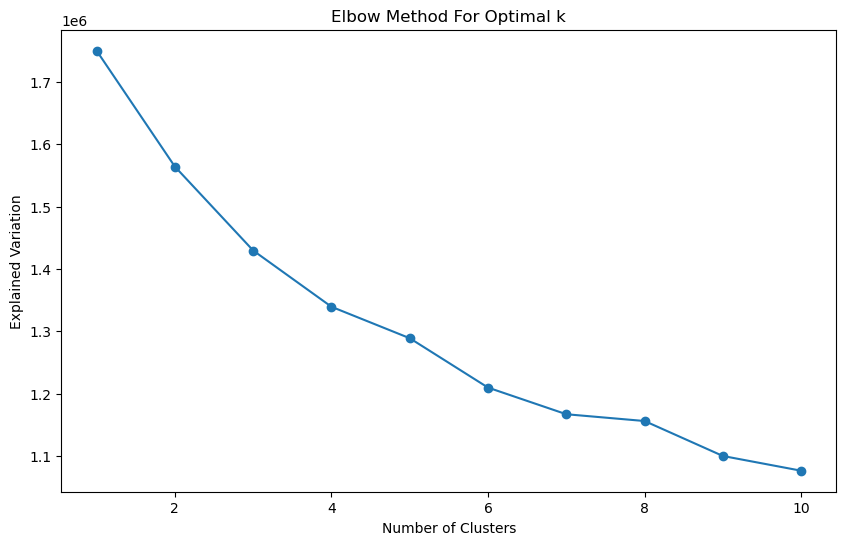

In [36]:
# Calculate the explained variation
explained_variation = []
K = range(1, 11)  # 1 to 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(cluster_features_scaled)
    explained_variation.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(K, explained_variation, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Explained Variation')
plt.show()


I'm going to pick 3 as my number of clusters

In [37]:
# Perform k means clustering:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
clusters = kmeans.fit_predict(cluster_features_scaled)

# Assign cluster labels (add as a feature)
data['cluster'] = clusters


<b>Visualize the clusters:</b>

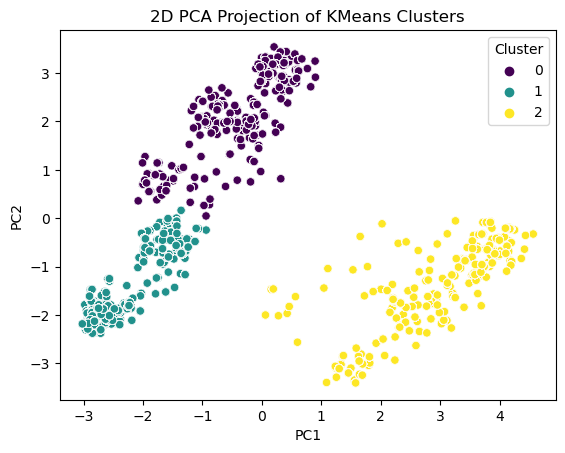

In [38]:
# Reduce dimensions with PCA

# Apply PCA and fit the features selected
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(cluster_features_scaled)

# Create a DataFrame with the two components
PCA_components = pd.DataFrame(principalComponents, columns=['PC1', 'PC2'])

# Add the cluster labels
PCA_components['Cluster'] = clusters

# Visualize the clusters
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=PCA_components, palette='viridis')
plt.title('2D PCA Projection of KMeans Clusters')
plt.show();

### CLUSTER PROFILING

In [39]:
# Get descriptive statistics:
# Select only the columns used for clustering and the cluster labels
cluster_data = data[['cluster'] + list(cluster_features.columns)]

# Calculate descriptive statistics for each cluster
cluster_summary = cluster_data.groupby('cluster').agg(['mean', 'std', 'median'])
cluster_summary

redemption_rate                  age_desc_19-24                   \
                   mean       std median           mean       std median   
cluster                                                                    
0              0.404020  0.864629    0.0       0.047201  0.212075    0.0   
1              0.412387  0.904373    0.0       0.076420  0.265679    0.0   
2              0.606330  1.177957    0.0       0.055223  0.228424    0.0   

        age_desc_25-34                  age_desc_35-44                   \
                  mean       std median           mean       std median   
cluster                                                                   
0             0.124427  0.330079    0.0       0.209860  0.407222    0.0   
1             0.153639  0.360616    0.0       0.205797  0.404297    0.0   
2             0.250595  0.433373    0.0       0.336178  0.472420    0.0   

        age_desc_45-54                  age_desc_55-64                   \
                  mean       std median           mean       std median   
cluster                                                                   
0             0.360623  0.480197    0.0       0.118384  0.323073    0.0   
1             0.413265  0.492437    0.0       0.070028  0.255203    0.0   
2             0.294330  0.455760    0.0       0.041930  0.200437    0.0   

        age_desc_65+                  marital_status_Married                   \
                mean       std median                   mean       std median   
cluster                                                                         
0           0.139504  0.346483    0.0               0.606361  0.488572    1.0   
1           0.080851  0.272617    0.0               0.000000  0.000000    0.0   
2           0.021744  0.145854    0.0               0.644539  0.478672    1.0   

        marital_status_Single                  marital_status_Unknown  \
                         mean       std median                   mean   
cluster                                                                 
0                    0.085751  0.280004    0.0               0.307888   
1                    0.261151  0.439278    0.0               0.738849   
2                    0.101994  0.302653    0.0               0.253467   

                         income_desc_100-124K                   \
              std median                 mean       std median   
cluster                                                          
0        0.461635    0.0             0.032697  0.177849    0.0   
1        0.439278    1.0             0.043586  0.204179    0.0   
2        0.435014    0.0             0.054566  0.227141    0.0   

        income_desc_125-149K                  income_desc_15-24K            \
                        mean       std median               mean       std   
cluster                                                                      
0                   0.043893  0.204864    0.0           0.074873  0.263194   
1                   0.009879  0.098907    0.0           0.118989  0.323787   
2                   0.094937  0.293140    0.0           0.078198  0.268494   

               income_desc_150-174K                  income_desc_175-199K  \
        median                 mean       std median                 mean   
cluster                                                                     
0          0.0             0.047583  0.212888    0.0             0.014313   
1          0.0             0.031818  0.175520    0.0             0.016490   
2          0.0             0.039222  0.194131    0.0             0.008534   

                         income_desc_200-249K                   \
              std median                 mean       std median   
cluster                                                          
0        0.118781    0.0             0.009097  0.094945    0.0   
1        0.127354    0.0             0.000000  0.000000    0.0   
2        0.091987    0.0             0.008205  0.090215    0.0  

There are too many features to be able to figure out what is different about these.  Roughly, I can see differences in: age, maritial status (married), homeowners, probable renters, homeowner unknown, household comp, kids (specifically, cluster 1 has kids, and the others don't). Cluster 1 is the one that is more distinct. 

<b> Now visualize the clusters using box plots </b>

In [40]:
# change data types from bool to int
new_cluster_data = cluster_data.copy()
bool_columns = new_cluster_data.select_dtypes(include=[bool]).columns
new_cluster_data[bool_columns] = new_cluster_data[bool_columns].astype(int)


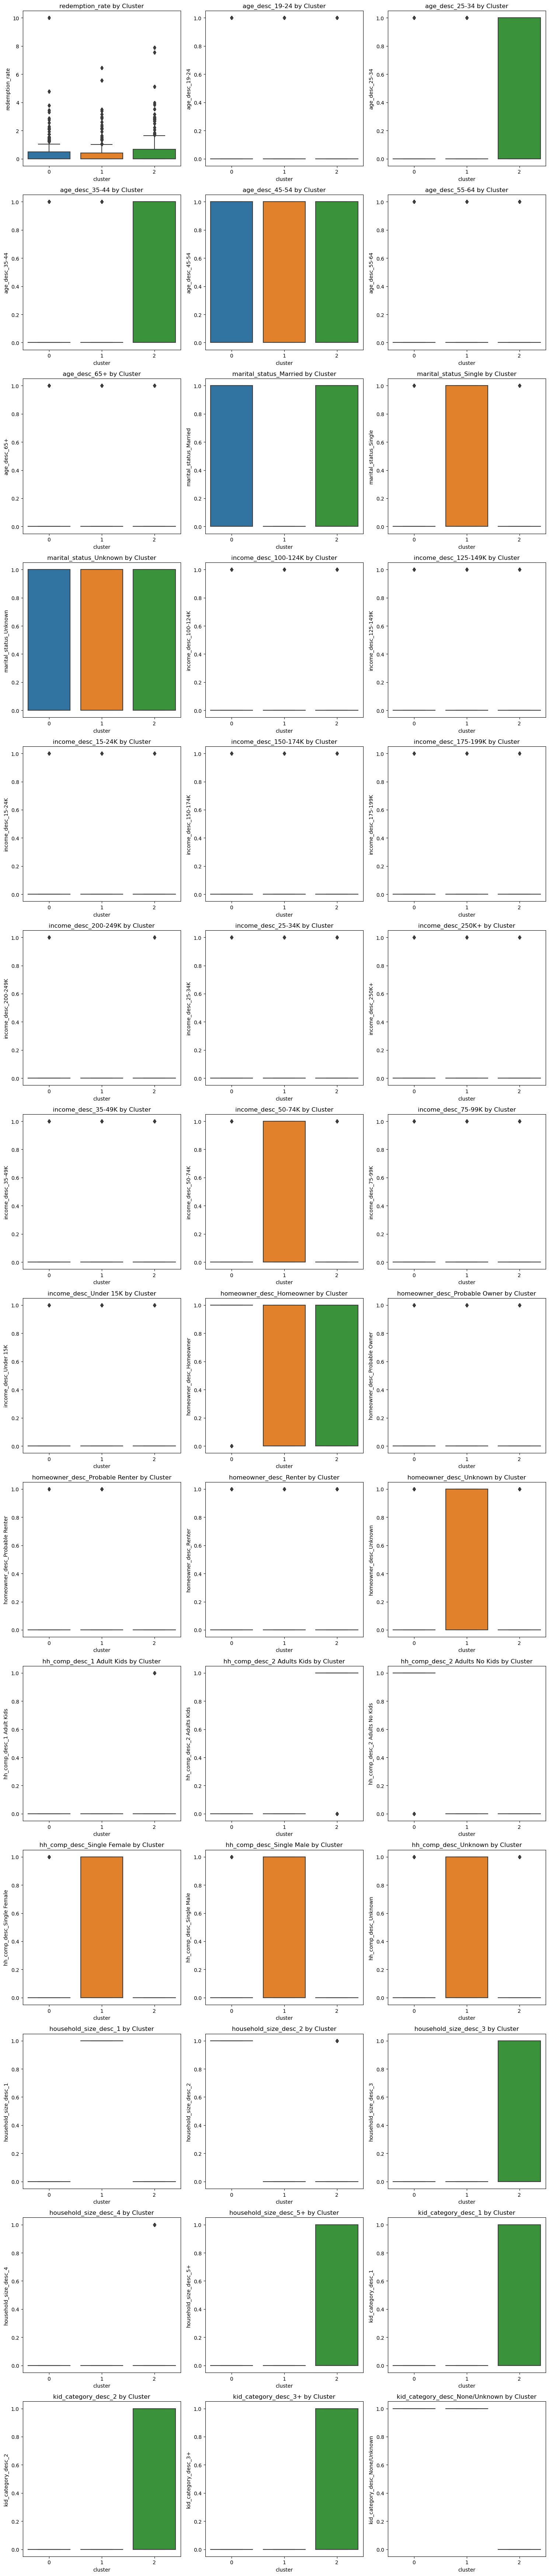

In [41]:
# Create a list of feature names
feature_names = [col for col in new_cluster_data.columns if col != 'cluster']

# Calculate the number of rows needed for the subplots
num_features = len(feature_names)
num_rows = -(-num_features // 3)  # Using the ceiling division trick

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Create a boxplot for each feature grouped by cluster
for i, feature in enumerate(feature_names):
    sns.boxplot(x='cluster', y=feature, data=new_cluster_data, ax=axes[i])
    axes[i].set_title(f'{feature} by Cluster')

# Remove any extra subplots
for i in range(num_features, num_rows * 3):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


### Difference between clusters

<b>Cluster 0: </b>

•	Married

<b>Cluster 1:</b>

•	Single

•	Income 50-74K

•	Homeowners

•	Unknown homeowners

•	Unknown household composition

<b>Cluster 2:</b>

•	Ages 25-44 

•	Married

•	Household size of 3, 5+

•	Everyone with kids

•	Higher redemption rate

<i>Basically, the single people with no kids are in group 0, the married people with no kids are in group 1, and the people with kids are in group 2.</i>


### 3.6.2 KNN Model  <a id='3.6.2'></a>

I will add the cluster number as a feature, and then build a KNN model. 

In [42]:
data.head()

,household_key,week_no,total_sales_value,redemption_rate,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_Married,marital_status_Single,marital_status_Unknown,income_desc_100-124K,income_desc_125-149K,income_desc_15-24K,income_desc_150-174K,income_desc_175-199K,income_desc_200-249K,income_desc_25-34K,income_desc_250K+,income_desc_35-49K,income_desc_50-74K,income_desc_75-99K,income_desc_Under 15K,homeowner_desc_Homeowner,homeowner_desc_Probable Owner,homeowner_desc_Probable Renter,homeowner_desc_Renter,homeowner_desc_Unknown,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown,cluster
0,1,33,123.86,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,0
1,1,34,42.80,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,0
2,1,36,80.45,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,0
3,1,38,72.82,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,0
4,1,40,113.07,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,0


In [43]:
# export data

data.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\results\data.csv", index=False)

In [44]:
# Drop the columns I don't want here, including the target
X = data.drop(columns= ['household_key', 'week_no', 'total_sales_value'], axis=1)  
y = data['total_sales_value']


# Scale the data - don't need to do this with the binary ones

cols_to_scale = ['redemption_rate']  

# Scale only identified column(s)

scaler = StandardScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

In [45]:
# NOTE: I'm doing a random split here, not based on time.

# Split data - try 90/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [46]:
# Initialize KNN Regressor model

knn = KNeighborsRegressor(n_neighbors=3)  # You can change the number of neighbors


In [47]:
# Train the model

knn.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=3)

In [48]:
# Make predictions on the test set
y_pred = knn.predict(X_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Mean Absolute Percentage Error: {mape}')


Mean Absolute Percentage Error: 15339755928481.447


<b>This error is similarly terrible to the last notebook. I suspect it is because I have a lot of outliers. </b>

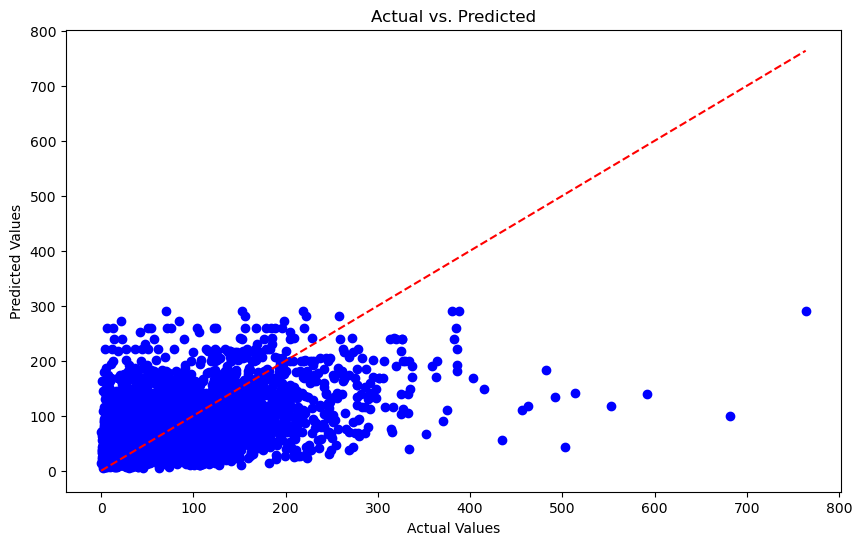

In [49]:
# Plot actual vs predicted values for the model

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()


In [50]:
# Also try some other metrics: 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

rmse, mae


(66.58732766464077, 47.8963515674984)

<b> Discussion: </b> I don't think KNN is a good model for this, and MAPE doesn't work as an evaluation metric as many of my values are too small. 

Try XG Boost next, as that is good at determining feature importance. 

### 6.6.3 XGBoost - Regression  <a id='3.6.3'></a>

Do an XGB Regression model to see if I can predict what a customer will spend based on their demographics. I am including the clustering in the data.

In [51]:
# Initial model
xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mae_xgb = mean_absolute_error(y_test, y_pred)

feature_importance_xgb = xgb_model.feature_importances_

rmse_xgb, mae_xgb


(59.04970992599196, 42.43198053445102)

In [52]:
# What is the mean sales value of 
mean_y_train = y_train.mean()
print('Mean Sales Value of y Train: ', mean_y_train)

Mean Sales Value of y Train:  81.92775389948007


Ok, so my error is still high, but it's better than with KNN. 

<b> NOTE: I also tried splitting the data chronologically, and my error was worse, so doing random split </b>

<b>Based on the clusters I found above, and I am interested in splitting the data into clusters, running models on each, to see if the model works better.</b>

In [53]:
# add the total_sales_value back in to cluster_data
cluster_data.loc[:, 'total_sales_value'] = data['total_sales_value'].values



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [54]:
# Convert boolean columns to int

cluster_data = cluster_data.copy()
cluster_data.loc[:, bool_columns] = cluster_data.loc[:, bool_columns].astype(int)

In [55]:
cluster_0 = cluster_data[cluster_data['cluster']==0]
cluster_1 = cluster_data[cluster_data['cluster']==1]
cluster_2 = cluster_data[cluster_data['cluster']==2]
print('Shape cluster 0 : ', cluster_0.shape)
print('Shape cluster 1 : ', cluster_1.shape)
print('Shape cluster 2 : ', cluster_2.shape)

Shape cluster 0 :  (15720, 44)
Shape cluster 1 :  (13766, 44)
Shape cluster 2 :  (12187, 44)


In [56]:
# CLUSTER 0

X0 = cluster_0.drop(columns=['cluster', 'total_sales_value'])
y0 = cluster_0['total_sales_value']

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.1, random_state=42)

xgb_cluster0 = XGBRegressor()

xgb_cluster0.fit(X0_train, y0_train)

y0_pred = xgb_cluster0.predict(X0_test)

rmse_xgb_cluster0 = np.sqrt(mean_squared_error(y0_test, y0_pred))
mae_xgb_cluster0= mean_absolute_error(y0_test, y0_pred)

feature_importance_xgb_cluster0 = xgb_cluster0.feature_importances_

rmse_xgb_cluster0, mae_xgb_cluster0

(61.51933612848422, 43.84575150218022)

In [57]:
# CLUSTER 1

X1 = cluster_1.drop(columns=['cluster', 'total_sales_value'])
y1 = cluster_1['total_sales_value']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=42)

xgb_cluster1 = XGBRegressor()

xgb_cluster1.fit(X1_train, y1_train)

y1_pred = xgb_cluster1.predict(X1_test)

rmse_xgb_cluster1 = np.sqrt(mean_squared_error(y1_test, y1_pred))
mae_xgb_cluster1= mean_absolute_error(y1_test, y1_pred)

feature_importance_xgb_cluster1 = xgb_cluster1.feature_importances_

rmse_xgb_cluster1, mae_xgb_cluster1

(51.286886414731526, 37.470133276103454)

In [58]:
# CLUSTER 2

X2 = cluster_2.drop(columns=['cluster', 'total_sales_value'])
y2 = cluster_2['total_sales_value']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.1, random_state=42)

xgb_cluster2 = XGBRegressor()

xgb_cluster2.fit(X2_train, y2_train)

y2_pred = xgb_cluster2.predict(X2_test)

rmse_xgb_cluster2 = np.sqrt(mean_squared_error(y2_test, y2_pred))
mae_xgb_cluster2= mean_absolute_error(y2_test, y2_pred)

feature_importance_xgb_cluster2 = xgb_cluster2.feature_importances_

rmse_xgb_cluster2, mae_xgb_cluster2

(64.35802569178331, 47.37544705967516)

<b> Splitting by cluster shows no improvement. Not going to do this. </b>

<b>Let's deal with outliers now. Try Winsorizing: This method "clips" the extreme values to a specified percentile range.</b>

In [59]:
# Perform Winsorizing on the 'total_sales_value' column
# Here, we are setting the limits to 0.05 and 0.95, meaning the lowest 5% and the highest 5% of data will be clipped
data['winsorized_sales_value'] = mstats.winsorize(data['total_sales_value'], limits=[0.05, 0.05])


In [60]:
data.columns

Index(['household_key', 'week_no', 'total_sales_value', 'redemption_rate',
       'age_desc_19-24', 'age_desc_25-34', 'age_desc_35-44', 'age_desc_45-54',
       'age_desc_55-64', 'age_desc_65+', 'marital_status_Married',
       'marital_status_Single', 'marital_status_Unknown',
       'income_desc_100-124K', 'income_desc_125-149K', 'income_desc_15-24K',
       'income_desc_150-174K', 'income_desc_175-199K', 'income_desc_200-249K',
       'income_desc_25-34K', 'income_desc_250K+', 'income_desc_35-49K',
       'income_desc_50-74K', 'income_desc_75-99K', 'income_desc_Under 15K',
       'homeowner_desc_Homeowner', 'homeowner_desc_Probable Owner',
       'homeowner_desc_Probable Renter', 'homeowner_desc_Renter',
       'homeowner_desc_Unknown', 'hh_comp_desc_1 Adult Kids',
       'hh_comp_desc_2 Adults Kids', 'hh_comp_desc_2 Adults No Kids',
       'hh_comp_desc_Single Female', 'hh_comp_desc_Single Male',
       'hh_comp_desc_Unknown', 'household_size_desc_1',
       'household_size_desc_2'

In [61]:
# Run my model again

X_w=data.drop(columns=['winsorized_sales_value','household_key', 'week_no', 'total_sales_value'], axis=1)
y_w=data['winsorized_sales_value']

X_train_w, X_test_w, y_train_w, y_test_w= train_test_split(X_w, y_w, test_size=0.1, random_state=42)


# Initial model
xgb_model_w = XGBRegressor(objective ='reg:squarederror')

xgb_model_w.fit(X_train_w, y_train_w)

y_pred_w = xgb_model_w.predict(X_test_w)

rmse_xgb_w = np.sqrt(mean_squared_error(y_test_w, y_pred_w))
mae_xgb_w= mean_absolute_error(y_test_w, y_pred_w)

feature_importance_xgb = xgb_model_w.feature_importances_

rmse_xgb_w, mae_xgb_w


(49.979896500231554, 39.06651215728094)

<b> This is starting to get better, but I want to see if using IQR as a way to deal with my outliers may be better </b>

In [62]:
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR_value = iqr(y)

filtered_entries = ((y >= (Q1 - 1.5 * IQR_value)) & (y <= (Q3 + 1.5 * IQR_value)))
X_iqr, y_iqr = X[filtered_entries], y[filtered_entries]
X_train_iqr, X_test_iqr, y_train_iqr, y_test_iqr = train_test_split(X_iqr, y_iqr, test_size=0.1, random_state=42)
model_iqr = XGBRegressor()
model_iqr.fit(X_train_iqr, y_train_iqr)


y_pred_iqr = model_iqr.predict(X_test_iqr)

rmse_model_iqr = np.sqrt(mean_squared_error(y_test_iqr, y_pred_iqr))
mae_model_iqr = mean_absolute_error(y_test_iqr, y_pred_iqr)

rmse_model_iqr ,mae_model_iqr

(47.22461337873924, 36.81095616587445)

I'm going to go with IQR for my outliers. 

In [63]:
# Do hyperparameter turning:

# Define hyperparameters grid
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    model_iqr,
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    cv=5,
    random_state=42
)

# Fit the model
random_search.fit(X_train_iqr, y_train_iqr)

# Get best parameters
best_params = random_search.best_params_


Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [64]:
best_params

{'subsample': 0.8,
 'n_estimators': 200,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'colsample_bytree': 0.8}

In [65]:
random_search.best_score_

-2252.3657084058714

In [66]:
xgb_iqr = XGBRegressor(subsample= 0.8,n_estimators= 150, max_depth= 7, learning_rate= 0.05, gamma= 0.1, colsample_bytree= 0.5)
xgb_iqr.fit(X_train_iqr, y_train_iqr)

y_pred_xgb_iqr = model_iqr.predict(X_test_iqr)

rmse_xgb_iqr = np.sqrt(mean_squared_error(y_test_iqr, y_pred_xgb_iqr))
mae_xgb_iqr = mean_absolute_error(y_test_iqr, y_pred_xgb_iqr)

rmse_xgb_iqr ,mae_xgb_iqr

(47.22461337873924, 36.81095616587445)

<b>Discussion:</b>

XGBoost is the model that should work best with a complex dataset like what I am using, but it is looking like it will not result in a model which will be useful at predicting sales values. However, it <i>is</i> likely useful for indicating the directionality of sales, and I will be able to identify which features constribute to more or less spending. 


##  3.7 XGB Classification Initial Model: Will a customer use a coupon? <a id='3.7'></a>
I now will build an XGBoost Classification model to predict if a customer will be a coupon user or not. This is important because the company should target customers that use coupons in their coupon marketing campaigns.

In [67]:
# what's the breakdown of coupon users vs not in my training data?
unique_values, counts = np.unique(y_train, return_counts=True)
percent_coupon_users = (counts[1] / (counts[0]+counts[1])) *100
                        
                        
print(f"Unique values in y_train: {unique_values}")
print(f"Counts of each unique value: {counts}")
print(f"Percentage coupon users: {percent_coupon_users}")

Unique values in y_train: [1.20000e-01 2.00000e-01 2.50000e-01 ... 6.73990e+02 6.94970e+02
 1.28333e+03]
Counts of each unique value: [1 1 1 ... 1 1 1]
Percentage coupon users: 50.0


In [68]:
# Create new column to say if a customer uses a coupon or not, based on the coupnoo redemption rate. 
# Rates > 0 indicate coupon use.

data['coupon_user'] = np.where(data['redemption_rate'] > 0, 1, 0)


In [69]:
# Drop columns that are not needed for this model.
coupon_pred_data = data.drop(columns=['cluster','household_key', 'week_no', 'total_sales_value', 'winsorized_sales_value','redemption_rate'], axis=1)

In [70]:
coupon_pred_data.head()

,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_Married,marital_status_Single,marital_status_Unknown,income_desc_100-124K,income_desc_125-149K,income_desc_15-24K,income_desc_150-174K,income_desc_175-199K,income_desc_200-249K,income_desc_25-34K,income_desc_250K+,income_desc_35-49K,income_desc_50-74K,income_desc_75-99K,income_desc_Under 15K,homeowner_desc_Homeowner,homeowner_desc_Probable Owner,homeowner_desc_Probable Renter,homeowner_desc_Renter,homeowner_desc_Unknown,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown,coupon_user
0,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,1
1,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,1
2,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,1
3,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,1
4,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,1


In [71]:
# Train test split with 'coupon_user' as the target

X = coupon_pred_data.drop('coupon_user', axis=1)
y = coupon_pred_data['coupon_user']
# Split data - try 90/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [72]:
# TRY XG BOOST CLASSIFIER

xg_clf = XGBClassifier()
xg_clf.fit(X_train, y_train)
y_pred = xg_clf.predict(X_test)

In [73]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8642034548944337
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2331
           1       0.84      0.85      0.85      1837

    accuracy                           0.86      4168
   macro avg       0.86      0.86      0.86      4168
weighted avg       0.86      0.86      0.86      4168



Hey, this is pretty great! Let's see what happens with cross validation

In [74]:
xg_clf = XGBClassifier()

# Run cross-validation
cv_scores = cross_val_score(
    xg_clf, X, y, 
    cv=5, 
    scoring=make_scorer(recall_score, pos_label=1) 
)

print("Cross-validation recall scores:", cv_scores)
print("Mean recall:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())


Cross-validation recall scores: [0.51236264 0.4239011  0.46868132 0.3561418  0.52706788]
Mean recall: 0.4576309455864278
Standard Deviation: 0.06225255963339317


There is major overfitting.

<b> I have imbalanced classes. </b>

In [75]:
# To deal with class imbalance, first try scale_pos_weight feature of XG Boost

# Calculate scale_pos_weight value
scale_pos_weight_value = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize the XGBoost Classifier with scale_pos_weight
xgb_clf = XGBClassifier(scale_pos_weight=scale_pos_weight_value)

# Fit the model
xgb_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Further evaluation metrics like Precision, Recall, F1-Score
print(classification_report(y_test, y_pred))


Accuracy: 0.8622840690978887
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      2331
           1       0.80      0.92      0.85      1837

    accuracy                           0.86      4168
   macro avg       0.86      0.87      0.86      4168
weighted avg       0.87      0.86      0.86      4168



<b> I want to maximize recall, and it is 0.92 right now! </b>

In [76]:
# Run cross-validation
cv_scores = cross_val_score(
    xgb_clf, X, y, 
    cv=5, 
    scoring=make_scorer(recall_score, pos_label=1) 
)

print("Cross-validation recall scores:", cv_scores)
print("Mean recall:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

Cross-validation recall scores: [0.5293956  0.50357143 0.56346154 0.30557846 0.55784556]
Mean recall: 0.49197051780316414
Standard Deviation: 0.09563232357373451


This is slightly better than before, but not by much. There is still a lot of overfitting.

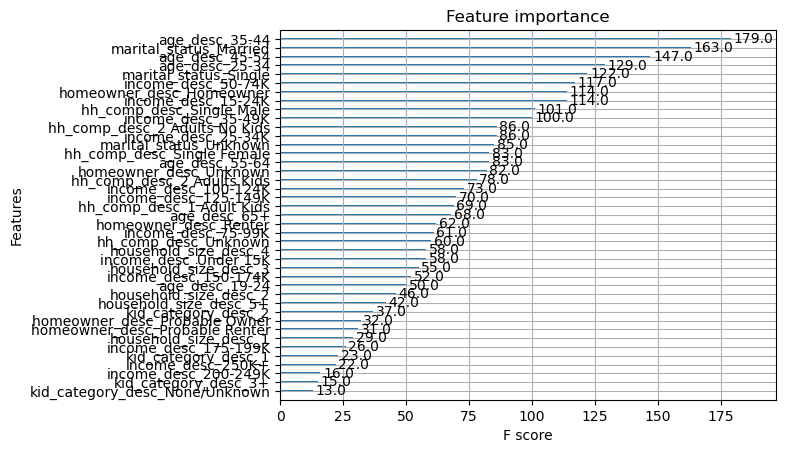

In [77]:
# Plot feature importance

plot_importance(xgb_clf)
plt.show()

We can see that the most important features are:
* Ages 35-44
* Married
* Ages 45-55
* Ages 25-44
* Single
* Income 50-74K
* Homeowner
* Income 15-24K
* Single Male
* Income 35-49

In [78]:
# Do cross validation & hyperparamter tuning 

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'recall',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X, y)

grid_search.best_estimator_

Fitting 10 folds for each of 96 candidates, totalling 960 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [79]:
# The best paramters:
best_parameters = grid_search.best_params_
print("Best Parameters:", best_parameters)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 180}


My Best Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 180}

In [80]:
# Run the model with the new parameters

# Calculate scale_pos_weight value
scale_pos_weight_value = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize the XGBoost Classifier with scale_pos_weight
tuned_xgb_clf = XGBClassifier(scale_pos_weight=scale_pos_weight_value, learning_rate=0.1, max_depth=8, n_estimators=180, objective='binary:logistic', nthread=4, seed=42)

# Fit the model
tuned_xgb_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = tuned_xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Further evaluation metrics like Precision, Recall, F1-Score
print(classification_report(y_test, y_pred))

# Run cross-validation
cv_scores = cross_val_score(
    tuned_xgb_clf, X, y, 
    cv=5, 
    scoring=make_scorer(recall_score, pos_label=1) 
)

print("Cross-validation recall scores:", cv_scores)
print("Mean recall:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

Accuracy: 0.8615642994241842
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      2331
           1       0.79      0.92      0.85      1837

    accuracy                           0.86      4168
   macro avg       0.86      0.87      0.86      4168
weighted avg       0.87      0.86      0.86      4168

Cross-validation recall scores: [0.51071429 0.45576923 0.44862637 0.42566639 0.55839516]
Mean recall: 0.479834289096449
Standard Deviation: 0.048192545668064024


<b>The original, untuned model was better</b>

<b> Given the terrible CV scores, I'd say my model is over-fitting </b>

### going back to my feature importance above...
Iterate through and remove features one by one, and see how that impacts my model performance

In [81]:
features_to_remove = []

# Initialize the best recall
best_recall = 0

X_temp = X.copy()

# Loop to iteratively remove features
while True:
    # Train the model using the current feature set
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.1, random_state=42, stratify=y)
    xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight_value)
    xgb_model.fit(X_train, y_train)
    
    # Get feature importances
    feature_importances = xgb_model.feature_importances_
    
    # Assess Performance
    y_pred = xgb_model.predict(X_test)
    current_recall = recall_score(y_test, y_pred)
    
    # Decision Point
    if current_recall >= best_recall:
        # Update best_recall
        best_recall = current_recall
        
        # Identify least important feature
        least_important = np.argmin(feature_importances)
        least_important_feature = X_temp.columns[least_important]
        
        # Remove Least Important Feature
        features_to_remove.append(least_important_feature)
        X_temp.drop([least_important_feature], axis=1, inplace=True)
        
    else:
        # if performance degrades
        break

features_to_remove, best_recall


(['kid_category_desc_3+', 'income_desc_200-249K'], 0.9032967032967033)

In [82]:
# Try removing these features and see if it makes a difference
X.drop(columns=['income_desc_15-24K', 'income_desc_150-174K'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Calculate scale_pos_weight value
scale_pos_weight_value = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize the XGBoost Classifier with scale_pos_weight
xgb_clf = XGBClassifier(scale_pos_weight=scale_pos_weight_value)

# Fit the model
xgb_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Further evaluation metrics like Precision, Recall, F1-Score
print(classification_report(y_test, y_pred))


Accuracy: 0.8622840690978887
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      2331
           1       0.80      0.92      0.85      1837

    accuracy                           0.86      4168
   macro avg       0.86      0.87      0.86      4168
weighted avg       0.87      0.86      0.86      4168



In [83]:
# cross-validation
cv_scores = cross_val_score(xgb_clf, X, y, cv=5, scoring='recall')

# Display cross-validation results
print("Cross-validation Recall Scores:", cv_scores)
print("Mean Recall Score:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))


Cross-validation Recall Scores: [0.5293956  0.50357143 0.56346154 0.30557846 0.55784556]
Mean Recall Score: 0.49197051780316414
Standard Deviation: 0.09563232357373451


It doesn't, so I will not remove any features.

## 3.8 DISCUSSION <a id='3.8'></a>


In this notebook, I built a table for modeling that included demographics , and I added redemption rate as a feature in my table for predicting weekly sales totals per customer. I took a 2 pronged approach, and worked on models for predicting weekly sales totals per customer, as well as one to predict if a customer will use a coupon or not based on their demographics. 
For the sales prediction model:

First I did K Means Clustering, where I identified 3 distinct clusters,  which divided mostly along the lines of single people with no kids, married couples with no kids, and people with kids. 
I then ran a KNN model, where I included redemption_rate as a feature, and the MAPE error was extremely high, and my actual vs predicted plot did not follow any kind of trend. The mean absolute error was 48, which is high considering that the mean sales value is 82. 

Next, I ran an XG Boost regression model, and the MAE was slightly better at 42.  I also ran an XG Boost model on the clusters separately, but it did not improve my model. 

As my data has a lot of outliers, I compared Winsorizing and IQR methods for dealing with outliers, and found that with the IQR method my MAE went down to 37. Hyperparameter tuning did not improve the model. 
Just to see what would happen, I also tried Random Forest, and the results were about the same. 

The next model I built was to predict if a customer will or will not use coupons based on their demographics. I removed the redemption_rate feature from the data, and added a coupon_user feature, to use as my target, where ‘1’ indicates they used a coupon, and my recall of the positive class was how I primarily evaluated the models. 43% of the weekly sales totals used a coupon. 

I ran an XG Boost Classifier model, and the initial model had 0.86 recall, but my mean recall CV score was only 0.45.

I next tried to do deal with the imbalanced classes with the scale_pos_weight function of XGBClassifier. Doing this increased my recall score to 0.92, and slightly improved the cv recall score to 0.49. 

## 3.9 Next Steps<a id='3.9'></a>

I will need to make 2 separate notebooks: 1 for regression/sales predictions, 1 for classification/coupon prediction, and for each model I will do SHAP analysis to determine which demographics contribute to the target variable.

<b>For the Regression model:</b>

Plot a histogram of the residuals, and see how they are distributed. Also look at the actual vs predicted values.  Using IQR, select a subset of the data around the mean, run the model again, and then look at these distributions. 

Because I have an issue of heterogeneity, I will likely be able to determine directionality, but not an accurate prediction of customer spending based on demographics. After I build a model on my filtered data, I will then build a model on the full set without a train/test split, and then perform SHAP analysis. 

Finally, run the model with the split. 

<b>For the Classification model </b>

Address class imbalances with oversampling and undersampling, build XGBoost Classification model to predict customer coupon use, and finally do SHAP analysis to determine how the features contribute towards coupon use. 

The next notebook is titled '4 Dunnhumby Sales Prediction Model'.

## 3.10 Exporting the Data <a id='3.10'></a>

In [86]:
data.to_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\data.csv", index=False)
